<a href="https://colab.research.google.com/github/marinabar/hugging_face/blob/main/vkimg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Install necessary librairies



In [ ]:
!pip install -U transformers
!pip install accelerate

In [ ]:
!pip install datasets

In [3]:
!pip install evaluate

In [4]:
from huggingface_hub import notebook_login
notebook_login()

### Load dataset and defined training data

In [5]:
import datasets

In [6]:
from datasets import load_dataset

In [7]:
dataset = load_dataset("m1b/vkscoredata", split="train")
#create test split
dataset = dataset.train_test_split(test_size=0.2)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/19982 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/79928 [00:00<?, ? examples/s]

In [8]:
dataset["train"][19]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=540x360>,
 'SCORE': 7}

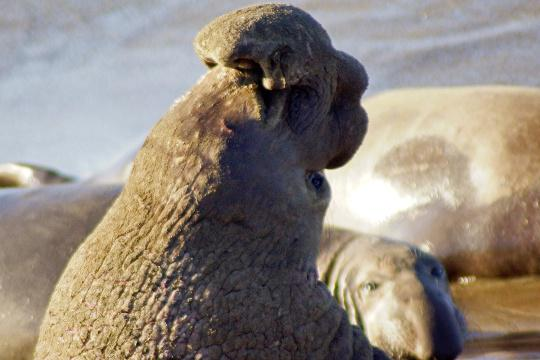

In [9]:
dataset["train"][19]["image"]

In [42]:
labels=["0","1","2","3","4","5","6","7","8","9", "10"]

In [29]:
dataset['train'].features

{'image': Image(decode=True, id=None), 'label': Value(dtype='int64', id=None)}

In [12]:
dataset = dataset.rename_column("SCORE", "label")

Create dicts mapping id to label name

In [43]:
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [39]:
batch_size = 2
model_config='google/vit-base-patch16-224-in21k'

In [44]:
print(id2label)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10'}


Here we are using ViT's config

### Augment data

In [16]:
from transformers import set_seed

set_seed(42)

In [17]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_config)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [18]:
from torchvision.transforms import CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, Resize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            Resize(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(examples):
    """Apply train_transforms across a batch."""
    examples["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in examples["image"]
    ]
    return examples

def preprocess_val(examples):
    """Apply val_transforms across a batch."""
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

Huggingface function to automatically map augmentation function and convert image to tensors

In [45]:
train_ds = dataset['train']
val_ds = dataset['test']

In [46]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

### Define metrics and analyzing function

In [47]:
import evaluate

accuracy = evaluate.load("accuracy")

In [22]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

### Define and train model

In [48]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_config,
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [50]:
for name, param in model.named_parameters():
    if 'classifier' not in name:
      param.requires_grad=False

In [ ]:
for name, param in model.named_parameters():
    print(name,param.requires_grad)

In [27]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [36]:
print(labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [52]:
# define hyperparameters
training_args = TrainingArguments(
    "vkimg", #name of the model we are going to save
    remove_unused_columns=False, # set as False otherwise will drop image coljmns
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    hub_model_id="m1b/vkimg"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor, #pre processing function
    compute_metrics=compute_metrics,# metrics function
    data_collator=collate_fn,
)

In [53]:
results=trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       4.98
  eval_accuracy           =     0.6909
  eval_loss               =     3.5497
  eval_runtime            = 0:04:16.70
  eval_samples_per_second =     59.016
  eval_steps_per_second   =      0.923


## Evaluate:

In [ ]:
from PIL import Image
import requests

url = 'https://images.saymedia-content.com/.image/ar_1:1%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cq_auto:eco%2Cw_1200/MTc0NDI1NDg2ODU4OTIxMzIw/cranked-up-french-onion-soup.jpg'
image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "m1b/foodievit"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [ ]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt")

The following is to use only in the case of model weights being already on the gpu

In [ ]:
encoding = encoding.to("cuda")

In [ ]:
import torch
# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

#get probabilities
prob=torch.nn.functional.softmax(logits, dim=1) #convert logits to prob
topprob=prob.sort(descending=True)[0][0][:5].tolist() # get top 5 prob
# get top five categories
top5=logits.argsort(descending=True)[0][:5].tolist()

print(*[f"Predicted {i+1} class: {model.config.id2label[(top5[i])]} - probability : {round(topprob[i], 4)} \n" for i in range(5)])

Predicted 1 class: french_onion_soup - probability : 0.037 
 Predicted 2 class: lasagna - probability : 0.0192 
 Predicted 3 class: croque_madame - probability : 0.0183 
 Predicted 4 class: macaroni_and_cheese - probability : 0.0175 
 Predicted 5 class: lobster_bisque - probability : 0.0143 



In [ ]:
dataset = load_dataset('food101', split='validation[:10%]')

In [ ]:
from evaluate import evaluator
task_evaluator = evaluator("image-classification")

eval_results = task_evaluator.compute(
    model_or_pipeline=model,
    data=dataset,
    label_mapping=model.config.label2id,
    feature_extractor=image_processor
)

In [ ]:
print(eval_results)

{'accuracy': 0.7275247524752475, 'total_time_in_seconds': 65.98596456500036, 'samples_per_second': 38.26571327168696, 'latency_in_seconds': 0.02613305527326747}
